In [ ]:
import os
import random
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.colors as plcolors

## Downloading Dataset

In [ ]:
!pip install gdown
# split and augmented hand selected dataset, removed all pixels < 200
!gdown --id 1Y7u6W9LP_4K07ameICvtqXmy5Osgccjq --output split_aug_hand-selected_dataset.zip
!unzip -q -o split_aug_hand-selected_dataset.zip -d '/content/traffic_sign_dataset'

Downloading...
From: https://drive.google.com/uc?id=1Y7u6W9LP_4K07ameICvtqXmy5Osgccjq
To: /content/split_aug_hand-selected_dataset.zip
121MB [00:01, 70.4MB/s]


In [ ]:
!pip install gdown
# randomly cropped, split and augmented hand selected dataset, removed all pixels < 200
!gdown --id 1eHH94llhlmmwJNlDzHoTbeo_djaJoD__ --output split_aug_hand-selected_dataset.zip
!unzip -q -o split_aug_hand-selected_dataset.zip -d '/content/traffic_sign_dataset'

Downloading...
From: https://drive.google.com/uc?id=1eHH94llhlmmwJNlDzHoTbeo_djaJoD__
To: /content/split_aug_hand-selected_dataset.zip
172MB [00:01, 130MB/s] 


In [ ]:
# Used to clear old torch.saves() for models in previous training runs
!rm -rf model_*

In [ ]:
# Used to remove old unzipped dataset and then unzip from fresh
!rm -rf traffic_sign*
#!rm -rf unique_dataset
!rm -rf alex_features
#!unzip -q -o cropped_mapillary_dataset.zip

## Splitting Images (IF USING ORIGINAL NON-SPLIT DATASET)

In [ ]:
classes = os.listdir("/content/traffic_sign_dataset/test")
classes = [x.split("--")[1] for x in classes]
print(classes)
with open('listfile.txt', 'w') as filehandle:
    for listitem in classes:
        filehandle.write('%s\n' % listitem)

['no-entry', 'no-turn-on-red', 'pedestrians-crossing', 'no-buses', 'disabled-persons', 'junction-with-a-side-road-perpendicular-right', 't-roads', 'go-straight', 'height-restriction', 'obstacle-delineator', 'go-straight-or-turn-left', 'maximum-speed-limit-45', 'road-closed', 'maximum-speed-limit-30', 'dual-lanes-go-straight-on-right', 'no-u-turn', 'divided-highway-ends', 'road-narrows-left', 'no-pedestrians', 'do-not-block-intersection', 'highway-exit', 'stop', 'dual-lanes-go-straight-on-left', 'reversible-lanes', 'curve-right', 'one-way-left', 'maximum-speed-limit-35', 'y-roads', 'keep-left', 'obstacle-delineator', 'maximum-speed-limit-100', 'wrong-way', 'roundabout', 'road-narrows-right', 'telephone', 'turn-right', 'maximum-speed-limit-55', 'double-curve-first-left', 'yield', 'airport', 'chevron-left', 'junction-with-a-side-road-perpendicular-left', 'no-overtaking', 'no-bicycles', 'maximum-speed-limit-40', 'no-right-turn', 'gas-station', 'narrow-bridge', 'bike-route', 'double-curve-f

In [ ]:
# Split the data into test, train, val folders
import shutil

dstpath = "/content/traffic_sign_dataset"
srcpath = "/content/unique_dataset/regulatory"
# Check that the dataset is balanced

def split_files(filelist, src, dst):
    for filename in filelist:
        shutil.move(
            os.path.join(src, filename), 
            os.path.join(dst, filename))

random.seed(1)
for classname in os.listdir(srcpath):
    classpath = os.path.join(srcpath, classname)
    train_dstpath = os.path.join(dstpath, "train", classname)
    val_dstpath = os.path.join(dstpath, "val", classname)
    test_dstpath =  os.path.join(dstpath, "test", classname)

    # Create empty test, train, val folders
    os.makedirs(train_dstpath, exist_ok=True)
    os.makedirs(val_dstpath, exist_ok=True)
    os.makedirs(test_dstpath, exist_ok=True)

    # Grab list of files and shuffle
    files = os.listdir(classpath)
    random.shuffle(files)

    # Split is Train: 75, Val: 15%, Test: 15%
    test_split = int(len(files) * 0.85)
    train_split = int(len(files) * 0.70)

    split_files(files[:train_split],
                classpath,
                train_dstpath)
    
    split_files(files[train_split:test_split],
                classpath,
                val_dstpath)
    
    split_files(files[test_split:],
                classpath,
                test_dstpath)

## Loading Data

### Trainset used for final trainin:

Number of samples in train: 48999
Number of samples in val: 6360
Number of samples in test: 6467


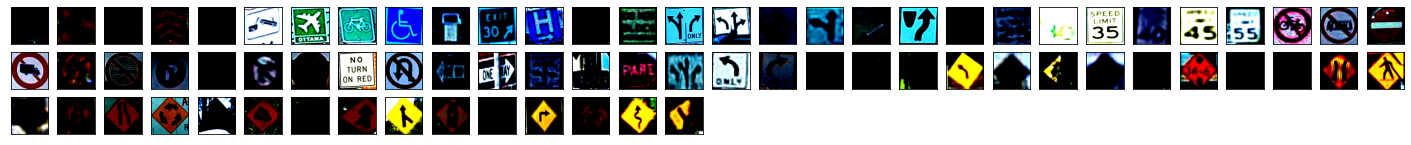

In [ ]:
# The output of torchvision datasets are PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1].
# We also force images to be 224x224

# Loaded files
master_path = "/content/traffic_sign_dataset"

transform = transforms.Compose(
    [transforms.Resize((224,224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]) # recommended for alexnet
     #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # default

# Load the traffic sign dataset
train_dataset = torchvision.datasets.ImageFolder(
    os.path.join(master_path, "train"),
    transform=transform)

val_dataset = torchvision.datasets.ImageFolder(
    os.path.join(master_path, "val"),
    transform=transform)

test_dataset = torchvision.datasets.ImageFolder(
    os.path.join(master_path, "test"),
    transform=transform)

classes = os.listdir(os.path.join(master_path, "train"))

# Print out the number of images in our train, val, test dataset
print("Number of samples in train: {}".format(len(train_dataset)))
print("Number of samples in val: {}".format(len(val_dataset)))
print("Number of samples in test: {}".format(len(test_dataset)))

# plot the images in the batch, along with the corresponding labels
# images printed out will look darker because of the normalization we have applied
label = -1
count = 0
fig = plt.figure(figsize=(25, 4))
for imgs, labels in train_dataset:
    if (label < labels):
        ax = fig.add_subplot(5, 30, count+1, xticks=[], yticks=[])
        imgs = torch.clamp(imgs, 0, 1) # Clamp is performed so that plt.imgshow can display images w/o warning
        plt.imshow(np.transpose(imgs, (1, 2, 0)))
        count += 1
        label = labels

### Produce trainset with no shift

In [ ]:
# create a trainset that only contains augmentation that is not shifting
import glob
import os
import shutil

root_trainset = "/content/traffic_sign_dataset/train"

# find all trainset name
trainset_all = set()
for class_name in os.listdir(root_trainset):
    class_dir = os.path.join(root_trainset,class_name)
    for img in os.listdir(class_dir):
        trainset_all.add(os.path.join(class_dir,img))
print(len(trainset_all))

48999


In [ ]:
# find all trainset name with shift
trainset_with_shift = set()
for class_name in os.listdir(root_trainset):
    class_dir = os.path.join(root_trainset,class_name)
    shift_imgs = glob.glob(os.path.join(class_dir,'*_shift_*.jpg'))
    trainset_with_shift.update(shift_imgs)

print(len(trainset_with_shift))

23854


In [ ]:
# find all non shift imgs
trainset_no_shift = trainset_all.difference(trainset_with_shift)
print(len(trainset_no_shift))

25145


In [ ]:
# copy trainset without shift to new location
no_shift_base = "/content/traffic_sign_dataset/no_shift_train"
os.makedirs(no_shift_base,exist_ok=True)
for img_no_shift in trainset_no_shift:
    class_name = img_no_shift.split('/')[4]
    dest = os.path.join(no_shift_base,class_name)
    os.makedirs(dest,exist_ok=True)
    shutil.copy(img_no_shift,dest)

### Produce trainset with no augmentation and no shift

In [ ]:
# find all trainset name with augmentation
trainset_with_aug = set()
for class_name in os.listdir(root_trainset):
    class_dir = os.path.join(root_trainset,class_name)
    shift_imgs = glob.glob(os.path.join(class_dir,'*_aug*.jpg'))
    trainset_with_aug.update(shift_imgs)

print(len(trainset_with_aug))

19192


In [ ]:
# find all the non shift and non aug imgs
trainset_no_shift_aug = trainset_no_shift.difference(trainset_with_aug)
print(len(trainset_no_shift_aug))

15372


In [ ]:
# copy trainset without shift and aug to new location
no_shift_aug_base = "/content/traffic_sign_dataset/no_shift_aug_train"
os.makedirs(no_shift_aug_base,exist_ok=True)
for img_no_shift_aug in trainset_no_shift_aug:
    class_name = img_no_shift_aug.split('/')[4]
    dest = os.path.join(no_shift_aug_base,class_name)
    os.makedirs(dest,exist_ok=True)
    shutil.copy(img_no_shift_aug,dest)

### Produce the dataset with shift but removes all augmentation

In [ ]:
trainset_no_aug = trainset_all.difference(trainset_with_aug)
print(len(trainset_no_aug))

29807


In [ ]:
# copy trainset without aug to new location
no_aug_base = "/content/traffic_sign_dataset/no_aug_train"
os.makedirs(no_aug_base,exist_ok=True)
for img_no_aug in trainset_no_aug:
    class_name = img_no_aug.split('/')[4]
    dest = os.path.join(no_aug_base,class_name)
    os.makedirs(dest,exist_ok=True)
    shutil.copy(img_no_aug,dest)

### Load the new trainsets

Number of samples in no shift train: 25145
Number of samples in no shift aug train: 15372
Number of samples in no aug train: 29807


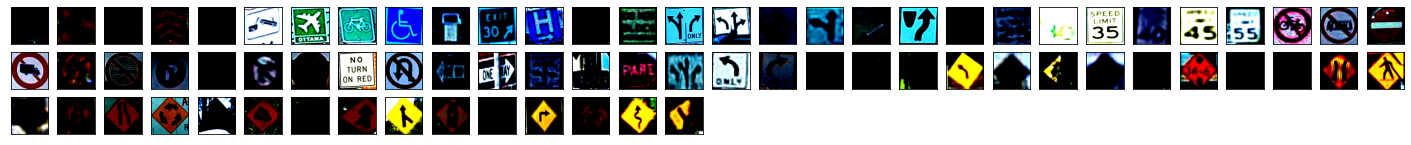

In [ ]:
# The output of torchvision datasets are PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1].
# We also force images to be 224x224

# Loaded files
master_path = "/content/traffic_sign_dataset"

transform = transforms.Compose(
    [transforms.Resize((224,224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]) # recommended for alexnet
     #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # default

# Load the traffic sign dataset
#train_no_shift_dataset = torchvision.datasets.ImageFolder(
    #os.path.join(master_path, "no_shift_train"),
    #transform=transform)

#train_no_shift_aug_dataset = torchvision.datasets.ImageFolder(
    #os.path.join(master_path, "no_shift_aug_train"),
    #transform=transform)

train_no_aug_dataset = torchvision.datasets.ImageFolder(
    os.path.join(master_path, "no_aug_train"),
    transform=transform)


classes = os.listdir(os.path.join(master_path, "train"))

# Print out the number of images in our train, val, test dataset
print("Number of samples in no shift train: {}".format(len(train_no_shift_dataset)))
print("Number of samples in no shift aug train: {}".format(len(train_no_shift_aug_dataset)))
print("Number of samples in no aug train: {}".format(len(train_no_aug_dataset)))

# plot the images in the batch, along with the corresponding labels
# images printed out will look darker because of the normalization we have applied
label = -1
count = 0
fig = plt.figure(figsize=(25, 4))
for imgs, labels in train_no_aug_dataset:
    if (label < labels):
        ax = fig.add_subplot(5, 30, count+1, xticks=[], yticks=[])
        imgs = torch.clamp(imgs, 0, 1) # Clamp is performed so that plt.imgshow can display images w/o warning
        plt.imshow(np.transpose(imgs, (1, 2, 0)))
        count += 1
        label = labels

## Training Functions

### Training Helper Function

In [ ]:
def get_model_name(name, batch_size, learning_rate, weight_decay, dropout,epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_wd{3}_dropout{4}_epoch{5}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   weight_decay,
                                                   dropout,
                                                   epoch)
    return path

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_acc.csv".format(path))
    val_err = np.loadtxt("{}_val_acc.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Accuracy")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

def get_accuracy(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (imgs, labels) in enumerate(data_loader):
            
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            
            output = model(imgs)
            # calculate the loss
            total_loss += float(criterion(output, labels))
            # select index with maximum prediction score
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(labels.view_as(pred)).sum().item()
            total += imgs.shape[0]
        
    loss = total_loss / (i+1)
    accuracy = correct / total
    return accuracy, loss

In [ ]:
import time

def train_net(model, train_loader, val_loader, batch_size=64, learning_rate=0.01, num_epochs=30, noise=False,weight_decay=0,dropout=0):
    torch.manual_seed(1000)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    train_acc, val_acc, train_loss, val_loss = [], [], [], []

    print("Training Started...")
    start_time = time.time()
    noise_val = 0.5
    n = 0
    for epoch in range(num_epochs):
        model.train() # for dropout
        for imgs, labels in iter(train_loader):
            
            if noise:
                imgs = imgs + noise_val * torch.randn(*imgs.shape)
                imgs = np.clip(imgs, -1., 1.)

            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()

            out = model(imgs)

            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Track accuracy
        train_stat = get_accuracy(model, train_loader, criterion)
        val_stat = get_accuracy(model, val_loader, criterion)
        train_acc.append(train_stat[0])
        train_loss.append(train_stat[1])
        val_acc.append(val_stat[0])
        val_loss.append(val_stat[1])

        print(("Epoch {}: Train acc: {}, Train loss: {} |"+
               "Validation acc: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_acc[-1],
                   train_loss[-1],
                   val_acc[-1],
                   val_loss[-1]))
        
        n += 1
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(model.name, batch_size, learning_rate, weight_decay, dropout, epoch)
        torch.save(model.state_dict(), model_path)


    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_acc.csv".format(model_path), val_acc)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Load Pretrained Model

In [ ]:
# alexnet
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth


### Other Pretrained Models

In [ ]:
import torch
import torch.nn as nn
import torchvision.models

'''NEED WORK!!!'''
# Extract feature of a chosen pretrained model if doesnt contrain .features()
class FeatureExtractor(nn.Module):
    def __init__(self,pretrained_model,end_of_feature):
        super(FeatureExtractor, self).__init__()
        self.net = pretrained_model
        # If you treat GooLeNet as a fixed feature extractor, disable the gradients and save some memory
        for p in self.net.parameters():
            p.requires_grad = False
        # Define which layers you are going to extract
        self.features_extracted = nn.Sequential(*list(self.net.children())[:end_of_feature])

    def features(self, x):
        return self.features_extracted(x)


In [ ]:
#googlenet
'''NOT WORKING/TAKING TOO LONG'''
import torchvision.models
googlenet = torchvision.models.googlenet(pretrained=True)
featureExtract = FeatureExtractor(googlenet)

In [ ]:
#vgg19
import torchvision.models
vgg19 = torchvision.models.vgg19(pretrained=True)

### Save features

In [ ]:
# Save the features to a file
def save_features(pretrained_model, data_loader, classes, path):
    for i, (img, label) in enumerate(data_loader):
        if use_cuda and torch.cuda.is_available():
            img = img.cuda()
            label = label.cuda()
        features = pretrained_model.features(img)
        output = open(os.path.join(path, classes[label], str(i) + ".torch"), mode='wb')
        torch.save(features, output)
        output.close()

In [ ]:
# Create seperate folders to contain the saved pretrained Features.
# To download these folders, you can use zip and then right click in sidebar to download.
def compute_features(pretrained_model,model_name,train_dataset,val_dataset,test_dataset):
    if use_cuda and torch.cuda.is_available():
        pretrained_model.cuda()
        print('CUDA is available!  Calculating on GPU ...')
    else:
        print('CUDA is not available.  Calculating on CPU ...')


    classes = train_dataset.classes
    for name in classes:
        os.makedirs(os.path.join("/content/{}_features/train/".format(model_name), name), exist_ok=True)
        os.makedirs(os.path.join("/content/{}_features/val/".format(model_name), name), exist_ok=True)
        os.makedirs(os.path.join("/content/{}_features/test/".format(model_name), name), exist_ok=True)

    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling

    train_loader = torch.utils.data.DataLoader(train_dataset)
    val_loader = torch.utils.data.DataLoader(val_dataset)
    test_loader = torch.utils.data.DataLoader(test_dataset)

    print("Train....")
    save_features(pretrained_model,train_loader, classes, "/content/{}_features/train".format(model_name))
    print("Validation....")
    save_features(pretrained_model,val_loader, classes, "/content/{}_features/val".format(model_name))
    print("Test....")
    save_features(pretrained_model,test_loader, classes, "/content/{}_features/test".format(model_name))


In [ ]:
# Compute the feature for the chosen pretrained model
pretrained_model = alexnet
pretrained_name = 'alex'
use_cuda = True

compute_features(pretrained_model=pretrained_model,model_name=pretrained_name,train_dataset=train_dataset,val_dataset=val_dataset,test_dataset=test_dataset)

CUDA is available!  Calculating on GPU ...
Train....
Validation....
Test....


### Load the 3 other trainset into **features**

In [ ]:
def compute_additional_features(pretrained_model,model_name,train_no_shift_dataset,train_no_shift_aug_dataset,train_no_aug_dataset):
    if use_cuda and torch.cuda.is_available():
        pretrained_model.cuda()
        print('CUDA is available!  Calculating on GPU ...')
    else:
        print('CUDA is not available.  Calculating on CPU ...')


    classes = train_no_shift_dataset.classes
    for name in classes:
        os.makedirs(os.path.join("/content/{}_features/train_no_shift/".format(model_name), name), exist_ok=True)
        os.makedirs(os.path.join("/content/{}_features/train_no_shift_aug/".format(model_name), name), exist_ok=True)
        os.makedirs(os.path.join("/content/{}_features/train_no_aug/".format(model_name), name), exist_ok=True)

    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling

    train_no_shift_loader = torch.utils.data.DataLoader(train_no_shift_dataset)
    train_no_shift_aug_loader = torch.utils.data.DataLoader(train_no_shift_aug_dataset)
    train_no_aug_loader = torch.utils.data.DataLoader(train_no_aug_dataset)

    print("Train no shift....")
    save_features(pretrained_model,train_no_shift_loader, classes, "/content/{}_features/train_no_shift".format(model_name))
    print("Train no shift and aug....")
    save_features(pretrained_model,train_no_shift_aug_loader, classes, "/content/{}_features/train_no_shift_aug".format(model_name))
    print("Train no aug....")
    save_features(pretrained_model,train_no_aug_loader, classes, "/content/{}_features/train_no_aug".format(model_name))

In [ ]:
compute_additional_features(pretrained_model=pretrained_model,model_name=pretrained_name,train_no_shift_dataset=train_no_shift_dataset,train_no_shift_aug_dataset=train_no_shift_aug_dataset,train_no_aug_dataset=train_no_aug_dataset)

CUDA is available!  Calculating on GPU ...
Train no shift....
Train no shift and aug....
Train no aug....


# Model Training and Hyperparameter Tuning

Chosen Model: model_signclassifierAdvancedWithDropout_bs256_lr3e-05_wd0.0001_dropout50_epoch52

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)
# This model with dropout with more Hidden Layers similar to alexnet
class SignClassifierAdvancedNetWithDropout(nn.Module):
    def __init__(self):
        super(SignClassifierAdvancedNetWithDropout, self).__init__()
        self.name = "signclassifierAdvancedWithDropout"
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096,1000)
        self.fc3 = nn.Linear(1000,75)
        self.dropout1 = nn.Dropout(0.5) # 50% dropout rate
        self.dropout2 = nn.Dropout(0.5)
        self.dropout3 = nn.Dropout(0.5)

    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6) #flatten feature data
        x = F.relu(self.fc1(self.dropout1(x)))
        x = F.relu(self.fc2(self.dropout2(x)))
        x = self.fc3(self.dropout3(x))
        return x

### Other Model:

In [ ]:
print(list(alexnet.children()))

[Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
), AdaptiveAvgPool2d(output_size=(6, 6)), Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_fe

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

# Starting Model
class SignClassifierNet(nn.Module):
    def __init__(self):
        super(SignClassifierNet, self).__init__()
        self.name = "SignClassifier"
        # self.conv1 = nn.Conv2d(256, 256, 3)
        # self.conv2 = nn.Conv2d(256, 256, 3)
        # self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 6 * 6, 800)
        self.fc2 = nn.Linear(800, 75)

    def forward(self, x):
        # x = F.leaky_relu(self.conv1(x))
        # x = F.leaky_relu(self.conv2(x))
        #print (x.shape)
        x = x.view(-1, 256 *6 * 6)
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)
# This model attemps to add more capacity to the model.
class SignClassifierNet(nn.Module):
    def __init__(self):
        super(SignClassifierNet, self).__init__()
        self.name = "signclassifier"
        self.fc1 = nn.Linear(256 * 6 * 6, 1600)
        self.fc2 = nn.Linear(1600, 75)

    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6) #flatten feature data
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)
# This model with dropout
class SignClassifierNetWithDropout(nn.Module):
    def __init__(self):
        super(SignClassifierNetWithDropout, self).__init__()
        self.name = "signclassifierWithDropout"
        self.fc1 = nn.Linear(256 * 6 * 6, 1600)
        self.fc2 = nn.Linear(1600,75)
        self.dropout1 = nn.Dropout(0.4) # 40% dropout rate
        self.dropout2 = nn.Dropout(0.4)

    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6) #flatten feature data
        x = F.relu(self.fc1(self.dropout1(x)))
        x = self.fc2(self.dropout2(x))
        return x

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)
# This model with dropout with even more Hidden Layers
class SignClassifierAdvancedV2NetWithDropout(nn.Module):
    def __init__(self):
        super(SignClassifierAdvancedV2NetWithDropout, self).__init__()
        self.name = "signclassifierAdvancedV2WithDropout"
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096,4096)
        self.fc3 = nn.Linear(4096,1600)
        self.fc4 = nn.Linear(1600,75)
        self.dropout1 = nn.Dropout(0.5) # 50% dropout rate
        self.dropout2 = nn.Dropout(0.5)
        self.dropout3 = nn.Dropout(0.5)
        self.dropout4 = nn.Dropout(0.5)

    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6) #flatten feature data
        x = F.relu(self.fc1(self.dropout1(x)))
        x = F.relu(self.fc2(self.dropout2(x)))
        x = F.relu(self.fc3(self.dropout3(x)))
        x = self.fc4(self.dropout4(x))
        return x

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)
# This model with dropout for vgg19
class SignClassifierNetWithDropoutVGG19(nn.Module):
    def __init__(self):
        super(SignClassifierNetWithDropoutVGG19, self).__init__()
        self.name = "signclassifierWithDropout"
        self.fc1 = nn.Linear(512*7*7, 4096)
        self.fc2 = nn.Linear(4096,4096)
        self.fc3 = nn.Linear(4096, 75)
        self.dropout1 = nn.Dropout(0.2) # 20% dropout rate
        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(-1, 512*7*7) #flatten feature data
        x = F.relu(self.fc1(self.dropout1(x)))
        x = F.relu(self.fc2(self.dropout2(x)))
        x = self.fc3(self.dropout3(x))
        return x

In [ ]:
# This model attemps to mimic what LeCunn used in his Traffic Sign Classifier
class LeNetModel(nn.Module):
    def __init__(self):
        super(LeNetModel, self).__init__() 
        self.name = "lenet"
        # in=32x32x3 out=6x28x28
        self.conv1 = nn.Conv2d(1, 6, 5) 
        self.pool = nn.MaxPool2d(2, 2) 
        # in=6x14x14 out=16x10x10
        self.conv2 = nn.Conv2d(6, 16, 5) 
        self.fc1 = nn.Linear(16 * 5 * 5, 800)
        self.dropout1 = nn.Dropout(0.4)
        self.dropout2 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(800, 75)  

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))    
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(self.dropout1(x)))
        x = self.fc2(self.dropout2(x))
        return x

### Load train, val and test

In [ ]:
torch.manual_seed(1)

# Load AlexNet features
def feature_loader(path):
    features = torch.load(path)
    if use_cuda and torch.cuda.is_available():
        return torch.from_numpy(features.detach().cpu().numpy())
    else:
        return torch.from_numpy(features.detach().numpy())

# Get a list containing the counts each class based on their class number
def get_class_counts(dataset):
    counts = [0] * len(dataset.classes)
    for i in dataset:
        counts[i[1]] += 1
    return counts

############################################# 
# Hyperparameters
use_cuda = True
#model = SignClassifierNet()
#model = SignClassifierNetWithDropout()
batch_size = 256

#############################################


############################################# 
# Load AlexNet Features
train_featureset = torchvision.datasets.DatasetFolder(
    "/content/{}_features/train".format(pretrained_name), 
    feature_loader, 
    extensions=".torch")
val_featureset = torchvision.datasets.DatasetFolder(
    "/content/{}_features/val".format(pretrained_name), 
    feature_loader, 
    extensions=".torch")
#############################################


############################################# 
# Load Raw JPG Images
# transform = transforms.Compose(
#     [transforms.Grayscale(),
#      transforms.Resize((32,32)),
#      transforms.ToTensor()])

# train_featureset = torchvision.datasets.ImageFolder(
#     "/content/traffic_sign_dataset/train",
#     transform=transform)
# val_featureset = torchvision.datasets.ImageFolder(
#     "/content/traffic_sign_dataset/val",
#     transform=transform)
#############################################


############################################# 
# For Training we use need to balance the data during training
# Shuffle the targets
target_list = torch.tensor(train_featureset.targets)
target_list = target_list[torch.randperm(len(train_featureset))]
# Calculate the weights
class_sample_count = get_class_counts(train_featureset)
weights = 1. / torch.Tensor(class_sample_count)
class_weights_all = weights[target_list]
# Construct the sampler
sampler = torch.utils.data.sampler.WeightedRandomSampler(class_weights_all, len(class_weights_all))
train_loader = torch.utils.data.DataLoader(train_featureset, 
                                           batch_size=batch_size, 
                                           num_workers=0, 
                                           sampler=sampler)
#############################################


val_loader = torch.utils.data.DataLoader(val_featureset, 
                                         batch_size=batch_size, 
                                         num_workers=0)


### Load the other trainsets

In [ ]:
torch.manual_seed(1)

# Load AlexNet features
def feature_loader(path):
    features = torch.load(path)
    if use_cuda and torch.cuda.is_available():
        return torch.from_numpy(features.detach().cpu().numpy())
    else:
        return torch.from_numpy(features.detach().numpy())

# Get a list containing the counts each class based on their class number
def get_class_counts(dataset):
    counts = [0] * len(dataset.classes)
    for i in dataset:
        counts[i[1]] += 1
    return counts

############################################# 
# Hyperparameters
use_cuda = True
#model = SignClassifierNet()
#model = SignClassifierNetWithDropout()
batch_size = 256

#############################################


############################################# 
# Load AlexNet Features
train_no_shift_featureset = torchvision.datasets.DatasetFolder(
    "/content/{}_features/train_no_shift".format(pretrained_name), 
    feature_loader, 
    extensions=".torch")
train_no_shift_aug_featureset = torchvision.datasets.DatasetFolder(
    "/content/{}_features/train_no_shift_aug".format(pretrained_name), 
    feature_loader, 
    extensions=".torch")
train_no_aug_featureset = torchvision.datasets.DatasetFolder(
    "/content/{}_features/train_no_aug".format(pretrained_name), 
    feature_loader, 
    extensions=".torch")
#############################################


############################################# 
# Load Raw JPG Images
# transform = transforms.Compose(
#     [transforms.Grayscale(),
#      transforms.Resize((32,32)),
#      transforms.ToTensor()])

# train_featureset = torchvision.datasets.ImageFolder(
#     "/content/traffic_sign_dataset/train",
#     transform=transform)
# val_featureset = torchvision.datasets.ImageFolder(
#     "/content/traffic_sign_dataset/val",
#     transform=transform)
#############################################


############################################# 
# For Training we use need to balance the data during training
# Shuffle the targets
target_list_no_shift = torch.tensor(train_no_shift_featureset.targets)
target_list_no_shift = target_list_no_shift[torch.randperm(len(train_no_shift_featureset))]
# Calculate the weights
class_sample_count = get_class_counts(train_no_shift_featureset)
weights = 1. / torch.Tensor(class_sample_count)
class_weights_all = weights[target_list_no_shift]
# Construct the sampler
sampler = torch.utils.data.sampler.WeightedRandomSampler(class_weights_all, len(class_weights_all))
train_no_shift_loader = torch.utils.data.DataLoader(train_no_shift_featureset, 
                                           batch_size=batch_size, 
                                           num_workers=0, 
                                           sampler=sampler)
#############################################

target_list_no_shift_aug = torch.tensor(train_no_shift_aug_featureset.targets)
target_list_no_shift_aug = target_list_no_shift_aug[torch.randperm(len(train_no_shift_aug_featureset))]
# Calculate the weights
class_sample_count = get_class_counts(train_no_shift_aug_featureset)
weights = 1. / torch.Tensor(class_sample_count)
class_weights_all = weights[target_list_no_shift_aug]
# Construct the sampler
sampler = torch.utils.data.sampler.WeightedRandomSampler(class_weights_all, len(class_weights_all))
train_no_shift_aug_loader = torch.utils.data.DataLoader(train_no_shift_aug_featureset, 
                                           batch_size=batch_size, 
                                           num_workers=0, 
                                           sampler=sampler)
#############################################

target_list_no_aug = torch.tensor(train_no_aug_featureset.targets)
target_list_no_aug = target_list_no_aug[torch.randperm(len(train_no_aug_featureset))]
# Calculate the weights
class_sample_count = get_class_counts(train_no_aug_featureset)
weights = 1. / torch.Tensor(class_sample_count)
class_weights_all = weights[target_list_no_aug]
# Construct the sampler
sampler = torch.utils.data.sampler.WeightedRandomSampler(class_weights_all, len(class_weights_all))
train_no_aug_loader = torch.utils.data.DataLoader(train_no_aug_featureset, 
                                           batch_size=batch_size, 
                                           num_workers=0, 
                                           sampler=sampler)

In [ ]:
print(type(train_no_aug_loader))
for imgs, labels in iter(train_no_aug_loader):
    print(imgs.shape)
    break

<class 'torch.utils.data.dataloader.DataLoader'>
torch.Size([256, 1, 256, 6, 6])


# Train model

CUDA is available!  Training on GPU ...
Training Started...
Epoch 1: Train acc: 0.716055429702647, Train loss: 1.4112410843372345 |Validation acc: 0.7754716981132076, Validation loss: 1.0995972228050233
Epoch 2: Train acc: 0.8376497479540399, Train loss: 0.7736328185225526 |Validation acc: 0.8718553459119497, Validation loss: 0.611480947136879
Epoch 3: Train acc: 0.89669176921978, Train loss: 0.5297372744729122 |Validation acc: 0.9015723270440251, Validation loss: 0.44086886793375013
Epoch 4: Train acc: 0.9208351190840629, Train loss: 0.40104625451688963 |Validation acc: 0.9169811320754717, Validation loss: 0.35499394237995147
Epoch 5: Train acc: 0.9366313598236699, Train loss: 0.31896701579292613 |Validation acc: 0.9279874213836478, Validation loss: 0.30277454525232317
Epoch 6: Train acc: 0.9498765280924101, Train loss: 0.2655465448430429 |Validation acc: 0.9327044025157233, Validation loss: 0.2700282622873783
Epoch 7: Train acc: 0.9562031878201596, Train loss: 0.22041964585271975 |Va

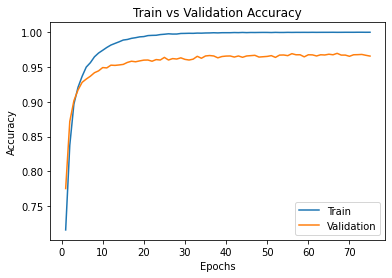

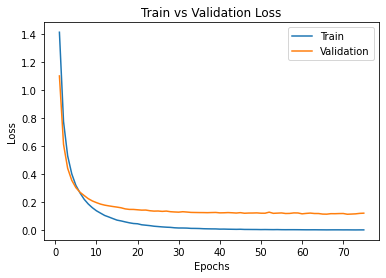

In [ ]:
num_epochs = 75
learning_rate = 0.00003
weight_decay = 0.0001
dropout = 50

#model = SignClassifierNetWithDropout() # for dropout
model = SignClassifierAdvancedNetWithDropout()
#model = SignClassifierAdvancedV2NetWithDropout()
#model = SignClassifierNet() # no dropout
if use_cuda and torch.cuda.is_available():
    model.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
    print('CUDA is not available.  Training on CPU ...')

# Train model
train_net(model, train_loader, val_loader, batch_size=batch_size, num_epochs=num_epochs, learning_rate=learning_rate, noise=False, weight_decay=weight_decay,dropout=dropout)

# Plot model
model_path = get_model_name(model.name, batch_size=batch_size, learning_rate=learning_rate, weight_decay=weight_decay, dropout=dropout, epoch=num_epochs-1)
plot_training_curve(model_path)

In [ ]:
# Used to clear old torch.saves() for models in previous training runs
!rm -rf model_*

In [ ]:
# save best state to Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import shutil
src = '/content/model_signclassifierAdvancedWithDropout_bs256_lr3e-05_wd0.0001_dropout50_epoch66'
dest = '/content/gdrive/My Drive/APS360/Project/TSC_saved'
shutil.copy(src,dest)

'/content/gdrive/My Drive/APS360/Project/TSC_saved/model_signclassifierAdvancedWithDropout_bs256_lr3e-05_wd0.0001_dropout50_epoch66'

### Test training performance of without shift

In [ ]:
print(len(train_no_shift_loader))

99


CUDA is available!  Training on GPU ...
Training Started...
Epoch 1: Train acc: 0.5864784251342215, Train loss: 1.9893719499761409 |Validation acc: 0.6080188679245283, Validation loss: 1.8498506051301957
Epoch 2: Train acc: 0.7894611254722609, Train loss: 1.0718151156348412 |Validation acc: 0.7580188679245283, Validation loss: 1.0956766682863235
Epoch 3: Train acc: 0.8742095844104195, Train loss: 0.7278226318985525 |Validation acc: 0.8367924528301887, Validation loss: 0.8060682559013367
Epoch 4: Train acc: 0.9107178365480215, Train loss: 0.5346959528296885 |Validation acc: 0.8633647798742138, Validation loss: 0.6520793282985687
Epoch 5: Train acc: 0.9216146351163254, Train loss: 0.4330718752109643 |Validation acc: 0.8683962264150943, Validation loss: 0.5679036983847618
Epoch 6: Train acc: 0.9437263869556571, Train loss: 0.3406173451380296 |Validation acc: 0.8817610062893082, Validation loss: 0.5071202635765075
Epoch 7: Train acc: 0.9531914893617022, Train loss: 0.2885832431340458 |Vali

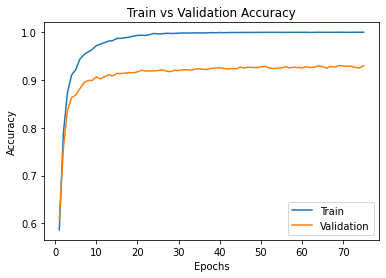

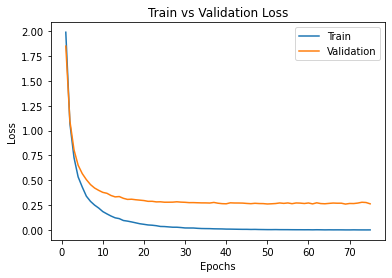

In [ ]:
num_epochs = 75
learning_rate = 0.00003
weight_decay = 0.0001
dropout = 50

#model = SignClassifierNetWithDropout() # for dropout
model = SignClassifierAdvancedNetWithDropout()
#model = SignClassifierAdvancedV2NetWithDropout()
#model = SignClassifierNet() # no dropout
if use_cuda and torch.cuda.is_available():
    model.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
    print('CUDA is not available.  Training on CPU ...')

# Train model
train_net(model, train_no_shift_loader, val_loader, batch_size=batch_size, num_epochs=num_epochs, learning_rate=learning_rate, noise=False, weight_decay=weight_decay,dropout=dropout)

# Plot model
model_path = get_model_name(model.name, batch_size=batch_size, learning_rate=learning_rate, weight_decay=weight_decay, dropout=dropout, epoch=num_epochs-1)
plot_training_curve(model_path)

In [ ]:
# Used to clear old torch.saves() for models in previous training runs
!rm -rf model_*

### Testing training performance without shift and augmentation

In [ ]:
print(len(train_no_shift_aug_loader))

61


CUDA is available!  Training on GPU ...
Training Started...
Epoch 1: Train acc: 0.5890580275826177, Train loss: 2.919417776045252 |Validation acc: 0.4803459119496855, Validation loss: 3.2258623313903807
Epoch 2: Train acc: 0.8235753317720531, Train loss: 1.546804166230999 |Validation acc: 0.7334905660377359, Validation loss: 1.9011414098739623
Epoch 3: Train acc: 0.8925318761384335, Train loss: 0.979695125681455 |Validation acc: 0.8067610062893081, Validation loss: 1.3235742950439453
Epoch 4: Train acc: 0.9182930002602133, Train loss: 0.7033980234724576 |Validation acc: 0.8289308176100629, Validation loss: 1.055406905412674
Epoch 5: Train acc: 0.9342310694769711, Train loss: 0.5442177653312683 |Validation acc: 0.844811320754717, Validation loss: 0.8949049055576325
Epoch 6: Train acc: 0.9479573250065053, Train loss: 0.4267984621348928 |Validation acc: 0.8669811320754717, Validation loss: 0.7554037702083588
Epoch 7: Train acc: 0.9567395264116576, Train loss: 0.35698326542729236 |Validati

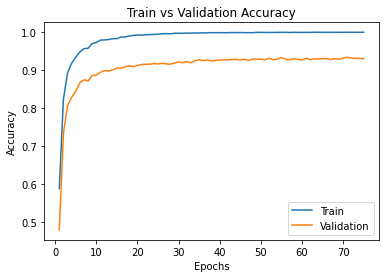

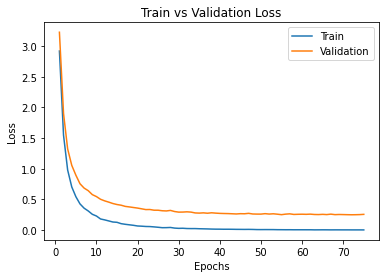

In [ ]:
num_epochs = 75
learning_rate = 0.00003
weight_decay = 0.0001
dropout = 50

#model = SignClassifierNetWithDropout() # for dropout
model = SignClassifierAdvancedNetWithDropout()
#model = SignClassifierAdvancedV2NetWithDropout()
#model = SignClassifierNet() # no dropout
if use_cuda and torch.cuda.is_available():
    model.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
    print('CUDA is not available.  Training on CPU ...')

# Train model
train_net(model, train_no_shift_aug_loader, val_loader, batch_size=batch_size, num_epochs=num_epochs, learning_rate=learning_rate, noise=False, weight_decay=weight_decay,dropout=dropout)

# Plot model
model_path = get_model_name(model.name, batch_size=batch_size, learning_rate=learning_rate, weight_decay=weight_decay, dropout=dropout, epoch=num_epochs-1)
plot_training_curve(model_path)

In [ ]:
# Used to clear old torch.saves() for models in previous training runs
!rm -rf model_*

### Test training on no augmentation but with shift

In [ ]:
print(len(train_no_aug_loader))

117


CUDA is available!  Training on GPU ...
Training Started...
Epoch 1: Train acc: 0.686684335894253, Train loss: 1.4406993134408934 |Validation acc: 0.6674528301886793, Validation loss: 1.5253773409128188
Epoch 2: Train acc: 0.8145402086758144, Train loss: 0.8164819647104312 |Validation acc: 0.779245283018868, Validation loss: 0.9280647075176239
Epoch 3: Train acc: 0.8845908679169323, Train loss: 0.5308568617727003 |Validation acc: 0.8360062893081761, Validation loss: 0.6731428039073944
Epoch 4: Train acc: 0.915724494246318, Train loss: 0.38622769713401794 |Validation acc: 0.8599056603773585, Validation loss: 0.5406605470180511
Epoch 5: Train acc: 0.9400811889824537, Train loss: 0.28885782732922805 |Validation acc: 0.885062893081761, Validation loss: 0.4515915805101395
Epoch 6: Train acc: 0.9517562988559735, Train loss: 0.23431842296551436 |Validation acc: 0.8992138364779875, Validation loss: 0.3984230500459671
Epoch 7: Train acc: 0.9617874995806355, Train loss: 0.19129950827003545 |Vali

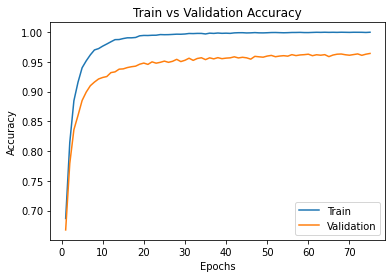

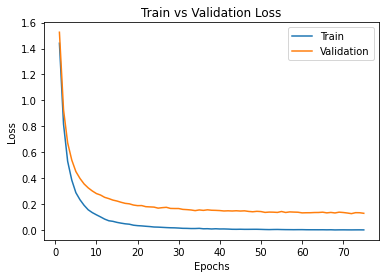

In [ ]:
num_epochs = 75
learning_rate = 0.00003
weight_decay = 0.0001
dropout = 50

#model = SignClassifierNetWithDropout() # for dropout
model = SignClassifierAdvancedNetWithDropout()
#model = SignClassifierAdvancedV2NetWithDropout()
#model = SignClassifierNet() # no dropout
if use_cuda and torch.cuda.is_available():
    model.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
    print('CUDA is not available.  Training on CPU ...')

# Train model
train_net(model, train_no_aug_loader, val_loader, batch_size=batch_size, num_epochs=num_epochs, learning_rate=learning_rate, noise=False, weight_decay=weight_decay,dropout=dropout)

# Plot model
model_path = get_model_name(model.name, batch_size=batch_size, learning_rate=learning_rate, weight_decay=weight_decay, dropout=dropout, epoch=num_epochs-1)
plot_training_curve(model_path)

In [ ]:
# Used to clear old torch.saves() for models in previous training runs
!rm -rf model_*

# Test model with testset

### Accuracy function that also counts interested classes

In [ ]:
def get_test_acc_confusion(model,data_loader,criterion,interested_classes):
    # convert extreme classes name to numerical representation
    class_TP_count = {} # TP
    class_FP_count = {} # FP
    class_FN_count = {} # FN
    class_pred_total_count = {} # for sanity check
    class_total_count = {} # just for easier math
    for class_name in interested_classes:
        class_TP_count[class_name] = 0
        class_FP_count[class_name] = 0
        class_FN_count[class_name] = 0
        class_pred_total_count[class_name] = 0
        class_total_count[class_name] = 0
    
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (imgs, labels) in enumerate(data_loader):
            
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            
            output = model(imgs)
            # calculate the loss
            total_loss += float(criterion(output, labels))
            # select index with maximum prediction score
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(labels.view_as(pred)).sum().item()
            total += imgs.shape[0]
            
            # count the intereted classes
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cpu()
                labels = labels.cpu()
                pred = pred.cpu()
            for i,label in enumerate(labels):
                class_name = train_dataset.classes[label.item()]
                pred_name = train_dataset.classes[pred[i].item()]
                       
                # check if current label or pred is what we're interested in
                if (class_name in interested_classes) or (pred_name in interested_classes):
                    if class_name in interested_classes:
                        class_total_count[class_name] += 1
                    if pred_name in interested_classes:
                        class_pred_total_count[pred_name] += 1
                    # if match, its TP
                    if pred_name == class_name:
                        class_TP_count[class_name] += 1
                    # if not match, could be FP or FN
                    else:
                        # if class_name is interested class, its FN
                        if class_name in interested_classes:
                            class_FN_count[class_name] += 1
                         # if pred_name is interested class, its FP
                        if pred_name in interested_classes:
                            class_FP_count[pred_name] += 1
                
                

        
    loss = total_loss / (i+1)
    accuracy = correct / total
    return accuracy, loss, class_total_count, class_TP_count, class_FP_count, class_FN_count, class_pred_total_count

### Find model performance on test set

In [ ]:
from google.colab import drive
drive.flush_and_unmount()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# load model
best_state = '/content/gdrive/My Drive/APS360/Project/TSC_saved/model_signclassifierAdvancedWithDropout_bs256_lr3e-05_wd0.0001_dropout50_epoch66'
model = SignClassifierAdvancedNetWithDropout()
state = torch.load(best_state)
model.load_state_dict(state)

<All keys matched successfully>

In [ ]:
# load test features
test_featureset = torchvision.datasets.DatasetFolder(
    "/content/{}_features/test".format(pretrained_name), 
    feature_loader, 
    extensions=".torch")
test_loader = torch.utils.data.DataLoader(test_featureset, 
                                         batch_size=batch_size, 
                                         num_workers=0)

In [ ]:
# find test performance
# define classes we're interested to find confusion matrix (TP,TN,FP,FN)
interested_classes = ['regulatory--yield--g1', # highest count
                      'regulatory--no-buses--g3', # lowest count
                      'regulatory--no-left-turn--g2', # ~130
                      'regulatory--reversible-lanes--g2', # ~300
                      'warning--traffic-signals--g3', # ~500
                      'regulatory--no-heavy-goods-vehicles--g2', # ~800
                      'regulatory--keep-right--g4', # ~1000
                      'regulatory--stop--g1' # ~2500
                      ]

criterion = nn.CrossEntropyLoss()
if use_cuda and torch.cuda.is_available():
    model.cuda()

accuracy, loss, class_total_count, class_TP_count, class_FP_count, class_FN_count, class_pred_total_count = get_test_acc_confusion(model,test_loader,criterion,interested_classes)
print("Test Accuracy is: {:.2f}%, Test Loss is: {}".format(accuracy*100,loss))

Test Accuracy is: 96.80%, Test Loss is: 0.045328062041593134


### Find some confusion matrix 

In [ ]:
for sign in interested_classes:
    sensitivity = class_TP_count[sign]/class_total_count[sign]
    precision = class_TP_count[sign]/class_pred_total_count[sign]
    #precision = class_TP_count[sign]/(class_TP_count[sign]+class_FP_count[sign])
    print("Class <{}>: TP count is {} with Sensitivity (TP rate) of {:.2f}% and Precision of {:.2f}%".format(sign,
                                                                                                 class_TP_count[sign],
                                                                                                 sensitivity*100,
                                                                                                 precision*100))

Class <regulatory--yield--g1>: TP count is 572 with Sensitivity (TP rate) of 99.48% and Precision of 99.13%
Class <regulatory--no-buses--g3>: TP count is 7 with Sensitivity (TP rate) of 53.85% and Precision of 77.78%
Class <regulatory--no-left-turn--g2>: TP count is 19 with Sensitivity (TP rate) of 90.48% and Precision of 95.00%
Class <regulatory--reversible-lanes--g2>: TP count is 46 with Sensitivity (TP rate) of 100.00% and Precision of 100.00%
Class <warning--traffic-signals--g3>: TP count is 73 with Sensitivity (TP rate) of 96.05% and Precision of 98.65%
Class <regulatory--no-heavy-goods-vehicles--g2>: TP count is 121 with Sensitivity (TP rate) of 95.28% and Precision of 96.03%
Class <regulatory--keep-right--g4>: TP count is 176 with Sensitivity (TP rate) of 99.44% and Precision of 100.00%
Class <regulatory--stop--g1>: TP count is 365 with Sensitivity (TP rate) of 96.05% and Precision of 99.46%


# For debugging

In [ ]:
best_state = '/content/gdrive/My Drive/APS360/Project/TSC_saved/model_signclassifierAdvancedWithDropout_bs256_lr3e-05_wd0.0001_dropout50_epoch66'
model = SignClassifierAdvancedNetWithDropout()
state = torch.load(best_state)
model.load_state_dict(state)

<All keys matched successfully>

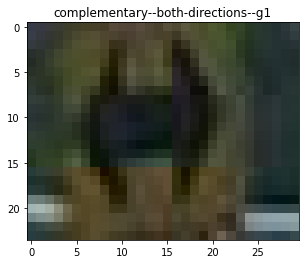

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

img_to_test = '/content/traffic_sign_dataset/val/complementary--both-directions--g1/1g72fvtvecxwsj0bxcmre6.jpg'
class_name = 'complementary--both-directions--g1'
img = Image.open(img_to_test)
plt.imshow(img)
plt.title(class_name)
plt.show
img = transform(img)

In [ ]:
input = torch.tensor(img).unsqueeze(0)
feature = alexnet.features(input)
output = model(feature)
pred = output.max(1,keepdim=True)[1]
classifier_pred = train_dataset.classes[pred]
print("Classifier predicts: ",classifier_pred)
print("Actual class: ",class_name)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


RuntimeError: ignored